In [3]:
# read dataframe
import pandas as pd
df = pd.read_pickle('frame_and_neuron_df.pickle')
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.002663,0.0,0.005849,0.002313,0.0,0.0,0.0,0.000000,1.205675,0.306645,0.000039,3.450070,0.813929,0.0,0.492323,0.217029,0.0,0.000000,0.001627,0.000029
1,0.002547,0.0,0.005638,0.002209,0.0,0.0,0.0,0.290215,1.580585,0.401094,0.000036,3.273390,0.964418,0.0,0.778266,0.208846,0.0,1.085661,0.001571,0.000027
2,0.002436,0.0,0.005435,0.002110,0.0,0.0,0.0,0.765249,1.799587,0.445118,0.000034,3.105744,0.975581,0.0,1.216320,0.200970,0.0,3.329352,0.001516,0.000025
3,0.002329,0.0,0.005239,0.002016,0.0,0.0,0.0,1.066364,1.914933,0.462616,0.000032,2.946674,0.929889,0.0,1.453981,0.193392,0.0,4.693593,0.001463,0.000023
4,0.002228,0.0,0.005050,0.001925,0.0,0.0,0.0,1.248395,1.961797,0.466225,0.000030,2.795744,0.871752,0.0,1.565819,0.186100,0.0,5.476060,0.001413,0.000022


In [4]:
import tkinter as tk
import cv2
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class PlotWindow:
    def __init__(self, parent, fr, neuron_df, video_path):
        self.parent = parent
        self.fr = fr
        self.neuron_df = neuron_df
        self.neuron_time_df = self.df_time()
        self.cap = cv2.VideoCapture(video_path)
        self.frame_num = 0
        
        self.slider_label = tk.Label(master=self.parent, text="Frame:")
        self.slider_label.pack(anchor = tk.NW)
        self.slider = tk.Scale(master=self.parent, from_=0, to=len(self.neuron_df)-1, orient=tk.HORIZONTAL)
        self.slider.pack(anchor = tk.NW, expand = True, fill = 'x')
        
        self.fig = self.init_plot()
        self.waveform_panel= FigureCanvasTkAgg(self.fig, master = self.parent)
        self.waveform_panel.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH)
        
        self.video_panel = tk.Label(master=self.parent)
        self.video_panel.pack(side=tk.RIGHT)
        self.update_frame(None)
        self.slider.bind("<ButtonRelease-1>", self.update_frame)
        
    def init_plot(self):
        self.fig, self.ax = plt.subplots(len(self.neuron_df.columns), 1, sharex = True)
        self.fig.supylabel('Neuron #')
        self.fig.supxlabel('Frame #')
        colors = plt.rcParams["axes.prop_cycle"]()
        for i, col in enumerate(self.neuron_df.columns):
            waveform = self.neuron_df[col].to_numpy()
            waveform = waveform / max(abs(waveform))
            c = next(colors)["color"]
            self.ax[i].plot(waveform, color = c)
            self.ax[i].set(ylabel = i +1)
            self.ax[i].axvline(x = 0, color = 'magenta')
            self.ax[i].set_yticklabels([])
            self.ax[i].spines['top'].set_color(None)
            self.ax[i].spines['bottom'].set_color(None)
            self.ax[i].spines['left'].set_color(None)
            self.ax[i].spines['right'].set_color(None)
            self.ax[i].set_yticks([])
        return self.fig
    
    def df_time(self):
        pd.TimedeltaIndex(self.neuron_df.index * (1/self.fr), unit = 's')
        self.neuron_time_df = self.neuron_df.copy()
        self.neuron_time_df.index = pd.TimedeltaIndex(self.neuron_df.index * (1/self.fr), unit = 's')
        return self.neuron_time_df
        
    def update_frame(self, Event):
        [self.ax[i].lines.pop(1) for i in range(len(self.ax))]
        for i, col in enumerate(self.neuron_df.columns):
            self.ax[i].axvline(x = int(self.slider.get()), color = 'magenta')
        self.waveform_panel.draw()
        
        # Get current frame number from slider
        self.frame_num = int(self.slider.get())
        
        # Get corresponding time stamp from dataframe, using the time dataframe
        self.time_stamp = self.neuron_time_df.index[self.frame_num]
        self.time_stamp = int(self.time_stamp.total_seconds() * 1000)
        
        # Set video capture position to corresponding time stamp
        self.cap.set(cv2.CAP_PROP_POS_MSEC, self.time_stamp)
        
        # Read frame from video
        self.ret, self.frame = self.cap.read()
        
        # Convert BGR to RGB color space
        self.frame = cv2.cvtColor(self.frame, cv2.COLOR_BGR2RGB)
    
        # Update video panel with new frame
        self.img = cv2.resize(self.frame, (640, 480))
        self.img = Image.fromarray(self.img)
        self.img = ImageTk.PhotoImage(image=self.img)
        self.video_panel.img = self.img
        self.video_panel.config(image=self.img)

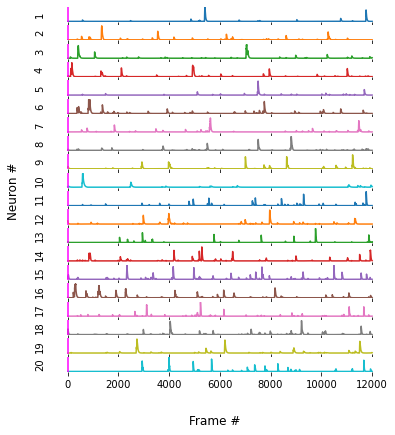

In [5]:
# your filepath to video will be different
root = tk.Tk()
plot_win = PlotWindow(root, 20.016, df, '/Users/andresvillegas/Documents/Experiments/calcium_imaging_experiments/exp25/mouse2_new/day1/video/day1_mouse2_int2_testcropped.mp4')
root.mainloop()